
#  **분석 목표**
<p>고객 이탈 감소를 위한 행동 기반 rule 발굴 및 액션 제안</p>



## 📌 Analysis Objective

The objective of this project is to identify customer churn patterns and propose actionable strategies by:
- Extracting interpretable decision rules from decision tree models
- Performing sensitivity analysis on key variables
- Estimating impact of behavioral changes on retention

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import gc

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
df = pd.read_csv('/content/drive/MyDrive/week_hands_on_project5/bank_churn/BankChurners_.csv')

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df.columns = df.columns.str.lower()

- 기본 demo :

      'customer_age,  'gender', 'dependent_count', 'education_level', 'marital_status','income_category'

- 고객 활동 이력 :  

      'months_on_book','months_inactive_12_mon', 'contacts_count_12_mon'

- 고객 관계 지표 :
      'total_relationship_count'

- 신용 정보 및 사용 내역 :
       'card_category',
       'credit_limit',
       'total_revolving_bal',   
       'avg_open_to_buy',   'total_trans_amt',
       'total_trans_ct', 'avg_utilization_ratio'


- 변화량 지표 :
         
      'total_amt_chng_q4_q1','total_ct_chng_q4_q1'






In [6]:
df.columns

Index(['clientnum', 'attrition_flag', 'customer_age', 'gender',
       'dependent_count', 'education_level', 'marital_status',
       'income_category', 'card_category', 'months_on_book',
       'total_relationship_count', 'months_inactive_12_mon',
       'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal',
       'avg_open_to_buy', 'total_amt_chng_q4_q1', 'total_trans_amt',
       'total_trans_ct', 'total_ct_chng_q4_q1', 'avg_utilization_ratio'],
      dtype='object')

In [7]:
print(df.shape)
df.head()

(10127, 21)


,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [8]:
df['attrition_flag'].unique()

attrition_mapping = {'Existing Customer': 0, 'Attrited Customer': 1}
df['attrition_flag'] = df['attrition_flag'].map(attrition_mapping)

# 데이터 이상 없는지 확인

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   clientnum                 10127 non-null  int64  
 1   attrition_flag            10127 non-null  int64  
 2   customer_age              10127 non-null  int64  
 3   gender                    10127 non-null  object 
 4   dependent_count           10127 non-null  int64  
 5   education_level           10127 non-null  object 
 6   marital_status            10127 non-null  object 
 7   income_category           10127 non-null  object 
 8   card_category             10127 non-null  object 
 9   months_on_book            10127 non-null  int64  
 10  total_relationship_count  10127 non-null  int64  
 11  months_inactive_12_mon    10127 non-null  int64  
 12  contacts_count_12_mon     10127 non-null  int64  
 13  credit_limit              10127 non-null  float64
 14  total_

In [10]:
# clientnum
df['clientnum'].nunique()
df['clientnum'].duplicated().sum()
df = df.drop('clientnum', axis=1)

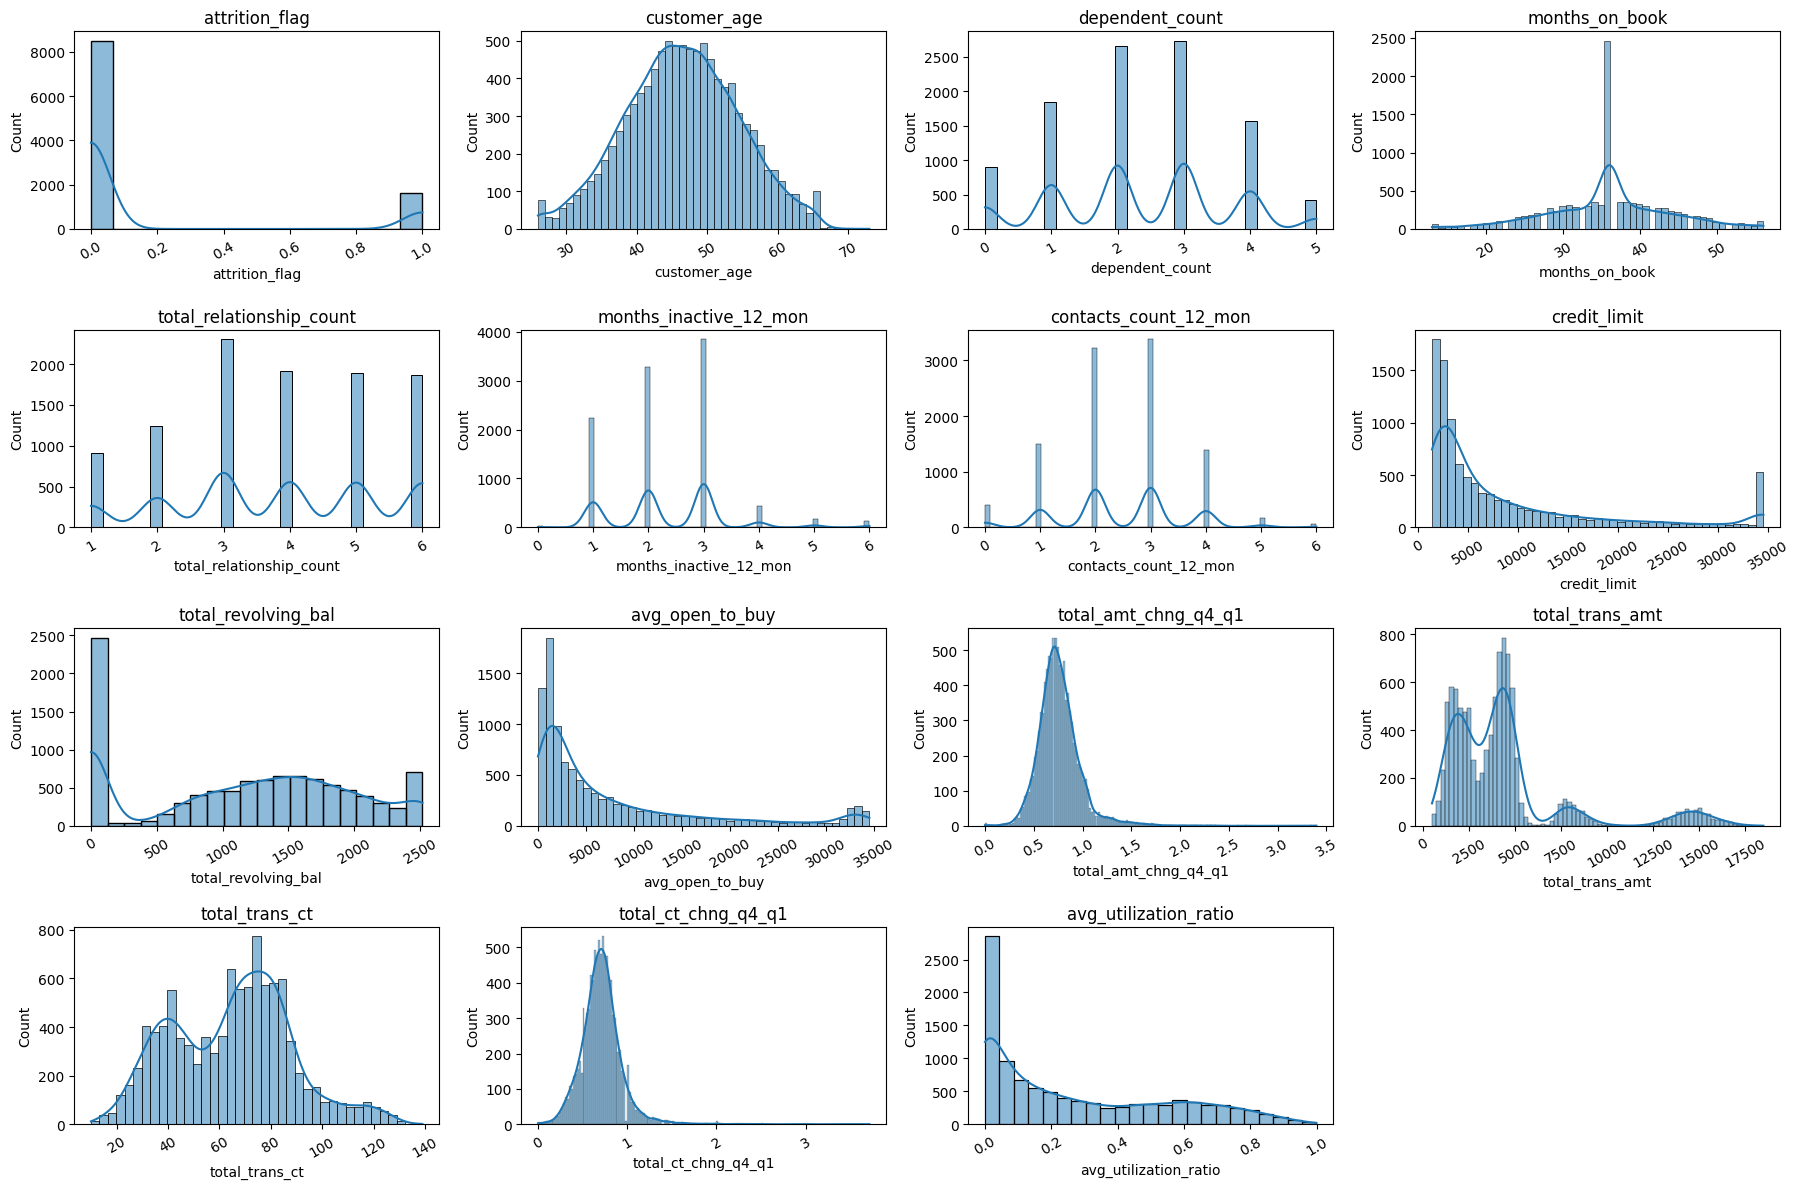

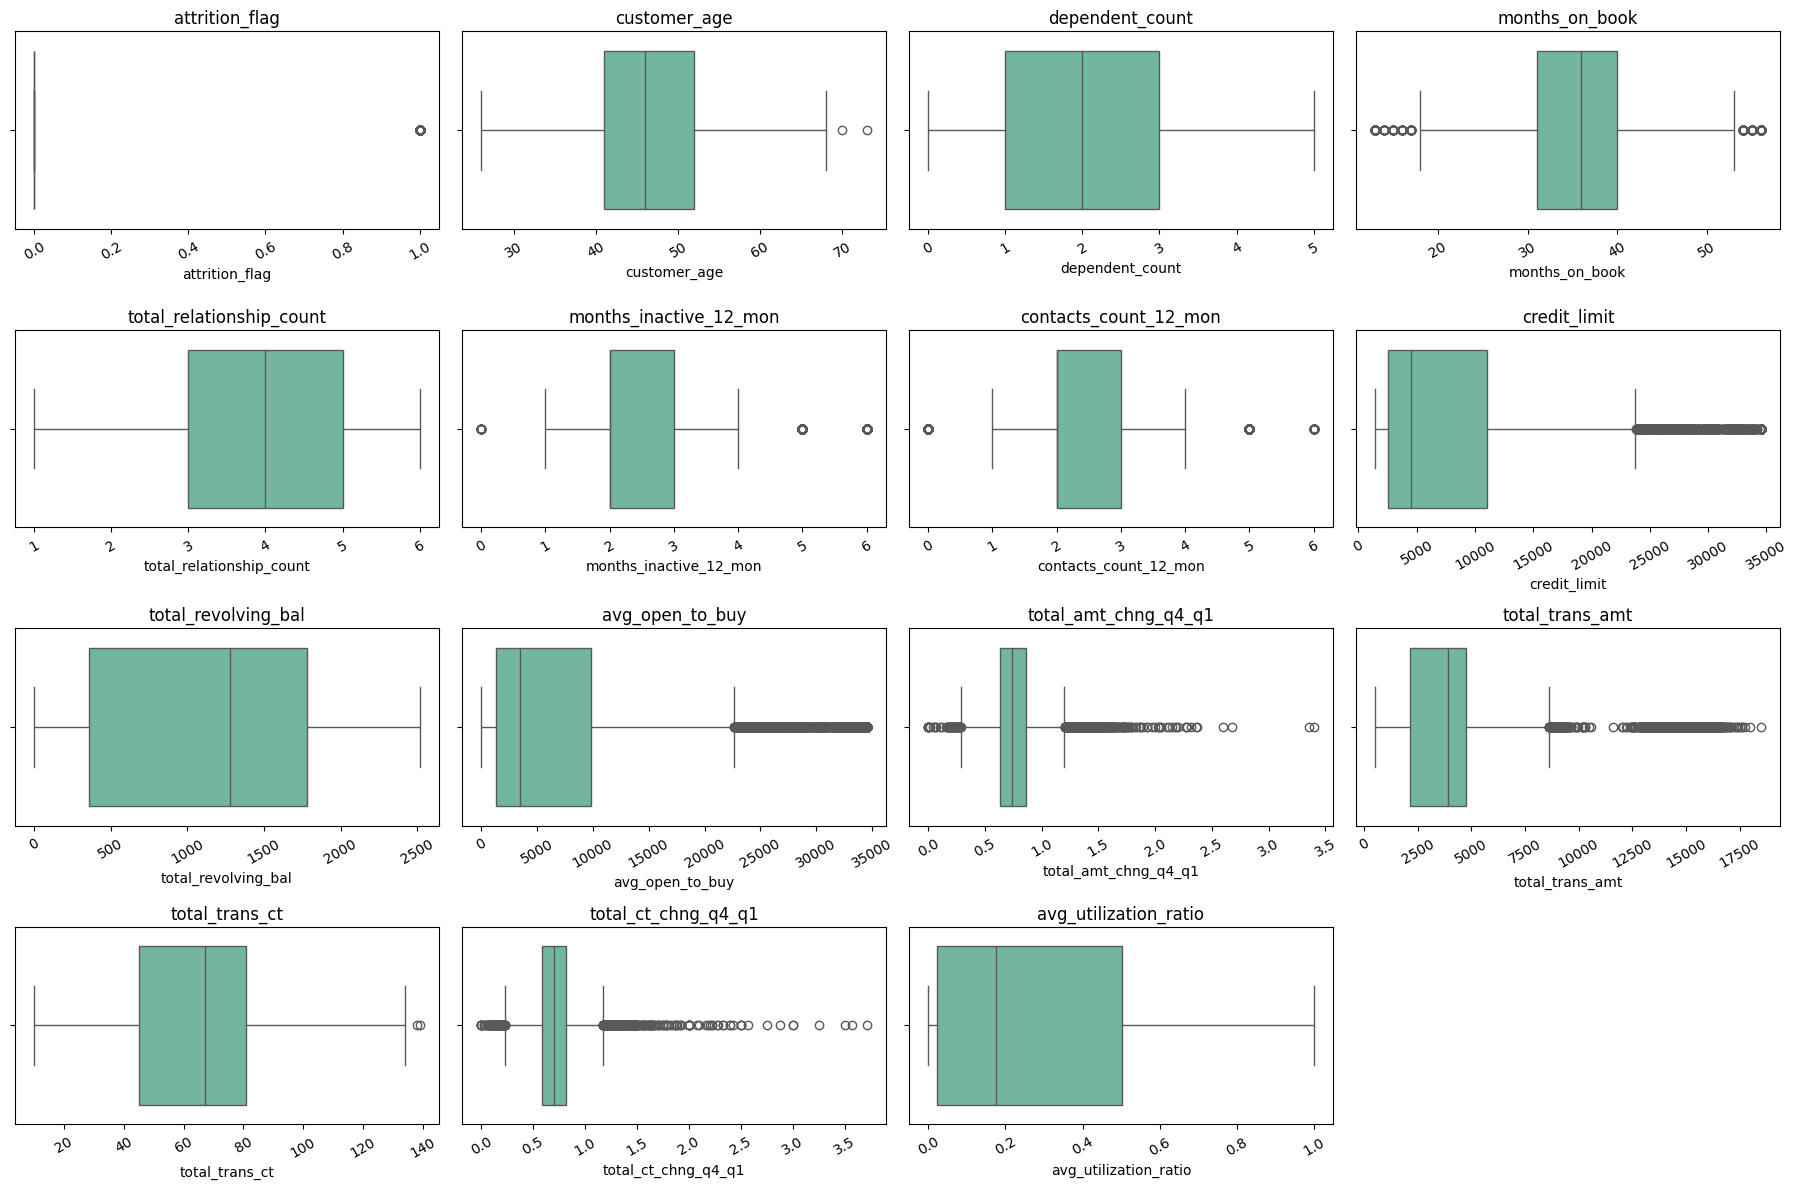

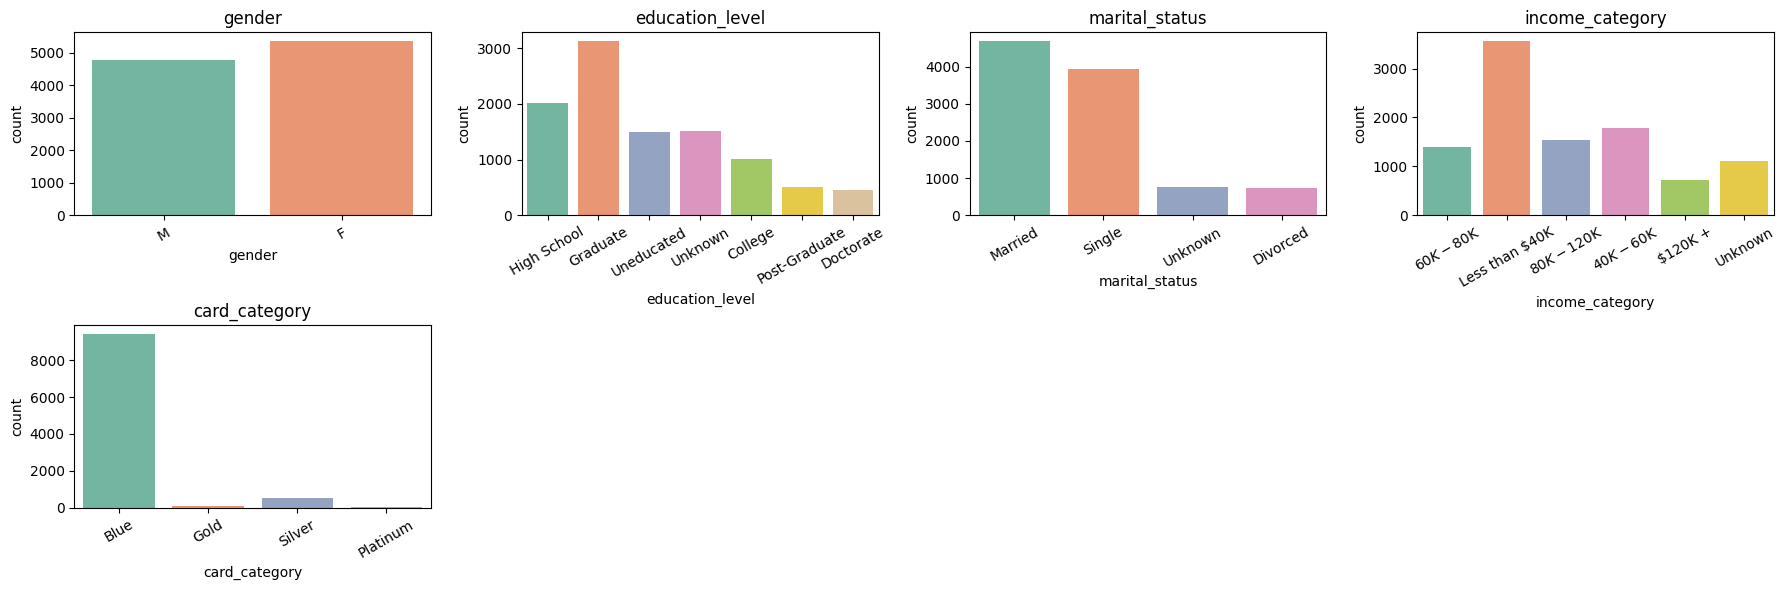

In [11]:
# 수치형 변수 <> 범주형 변수 구분
num_cols = []
cat_cols = []
for col in df.columns:
  if df[col].dtype == 'object':
    cat_cols.append(col)
  else:
    num_cols.append(col)


import math
# statistic visulization
def subplot_viz(columns,df, plot_type='hist'):
    rows = math.ceil(len(columns)/4)
    cols = 4

    fig, axes = plt.subplots(rows, cols, figsize=(18, 3*rows))
    axes = axes.flatten()

    for idx, col in enumerate(columns):
        if plot_type == 'hist':
            sns.histplot(data=df, x=col, kde=True, ax=axes[idx])

        elif plot_type == 'count':
            sns.countplot(data=df, x=col, ax=axes[idx], palette='Set2')
        elif plot_type == 'box':
            sns.boxplot(data=df, x=col, ax=axes[idx], palette='Set2')

        axes[idx].set_title(col)
        axes[idx].tick_params(axis='x', rotation=30)

    for empty in range(idx+1, len(axes)):
        fig.delaxes(axes[empty])

    plt.tight_layout()
    plt.show()

subplot_viz(num_cols, plot_type='hist', df=df)
subplot_viz(num_cols, plot_type='box',df=df)
subplot_viz(cat_cols, plot_type='count',df=df)


## 이상치 확인

In [12]:
def detect_outliers_iqr(df, features):
  outlier_summary = []

  for col in features:
    if not pd.api.types.is_numeric_dtype(df[col]):
      continue

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[ (df[col]<lower_bound) | (df[col]>upper_bound)]

    n_outliers = len(outliers)
    percent_of_outliers = ( n_outliers / len(df)) * 100

    outlier_summary.append({
        'feature': col,
        'n_outliers': n_outliers,
        'percent_of_outliers %': round(percent_of_outliers, 3),
        'lower_bound' : round(lower_bound , 3),
        'upper_bound' : round(upper_bound , 3)
    })
  return pd.DataFrame(outlier_summary).sort_values('percent_of_outliers %',ascending=False)


In [13]:
outlier_df = detect_outliers_iqr(df, num_cols)
display(outlier_df)

,feature,n_outliers,percent_of_outliers %,lower_bound,upper_bound
0,attrition_flag,1627,16.066,0.000,0.000
7,credit_limit,984,9.717,-10213.750,23836.250
9,avg_open_to_buy,963,9.509,-11477.250,22660.750
11,total_trans_amt,896,8.848,-1722.750,8619.250
6,contacts_count_12_mon,629,6.211,0.500,4.500
10,total_amt_chng_q4_q1,396,3.910,0.289,1.201
13,total_ct_chng_q4_q1,394,3.891,0.228,1.172
3,months_on_book,386,3.812,17.500,53.500
5,months_inactive_12_mon,331,3.268,0.500,4.500
1,customer_age,2,0.020,24.500,68.500


In [14]:
df.describe()

,attrition_flag,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,0.160660,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,0.367235,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,0.000000,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,0.000000,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,0.000000,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,0.000000,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,1.000000,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


# 주요 질문

- 전체 고객 수 및 이탈 고객 수
- 어떤 특성을 가진 고객들이 이탈 확률이 높은가? 이탈과 변수들 간의 상관관계 조사


In [15]:
print(f"전체 고객 수 : {df.shape[0]}\n이탈 고객 비중 : {len(df[df['attrition_flag']==1])/df.shape[0] * 100 :.3f}%")

전체 고객 수 : 10127
이탈 고객 비중 : 16.066%


In [16]:
df.head()

,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [17]:
# numerical values
from scipy.stats import pointbiserialr

target_col = 'attrition_flag'
numeric_cols_corr = df.select_dtypes(include=['number']).drop(columns=[target_col]).columns

results_corr = []
for col in numeric_cols_corr:
  corr, p = pointbiserialr(df[target_col],df[col])
  results_corr.append({'feature':col,
                       'corr':corr,
                       'p-value':round(p,10)})

corr_df = pd.DataFrame(results_corr)
corr_df.sort_values('corr', ascending=False)

,feature,corr,p-value
5,contacts_count_12_mon,0.204491,0.000000
4,months_inactive_12_mon,0.152449,0.000000
1,dependent_count,0.018991,0.056002
0,customer_age,0.018203,0.066987
2,months_on_book,0.013687,0.168437
8,avg_open_to_buy,-0.000285,0.977116
6,credit_limit,-0.023873,0.016285
9,total_amt_chng_q4_q1,-0.131063,0.000000
3,total_relationship_count,-0.150005,0.000000
10,total_trans_amt,-0.168598,0.000000


**<상관관계>**
- contatcts_count_12_mon : 최근 12개월간 고객과의 접촉 횟수가 높을수록 이탈률이 높다.
- months_inactive_12_mon : 최근 12개월 중 활동이 없던 월 수가 높을수록 이탈률이 높다.
- 유의하지 않을 수도 있지만 -> dependent_count 부양 가족 수가 많을 수록 이탈률 높다.
<br><br>
- total_trans_ct : 최근 12개월간 전체 거래 횟수가 적을수록 이탈률이 높다.
- total_ct_chng_q4_q1 : 최근 분기 간 거래 횟수 변화율 적을수록 이탈률이 높다.
- total_revolving_bal : 리볼빙 잔액 (회전 잔고), 즉 미결제 잔액이 적을수록 이탈률이 높다.
- avg_utilization_ratio : 평균 한도 사용률 (total_revolving_bal / credit_limit)이 적을수록 이탈률이 높다.
- total_trans_amt : 최근 12개월간 전체 거래 금액 적을수록 이탈률이 높다.

- total_relationship_count : 고객이 보유한 전체 상품 수 (예: 계좌 수, 카드 수 등) 적을수록 이탈률이 높다.
- 	total_amt_chng_q4_q1 : 최근 분기 간 소비 금액 변화율 (Q1 대비 Q4) 적을수록 이탈률이 높다.






** 🔴 민감도 분석 직후 마케팅 적용 대상/ 비대상 구분

서비스적인 부분 외에 금전적인 이유 등 불가피한 이유로 이탈한 고객들은 따로 분류할 필요가 있음.**

고려할 수 있는 변수들 :

 신용한도 대비 사용률
avg_utilization_ratio

회전 잔고 높으면 상환 부담 가능
total_revolving_bal

credit_limit

income_category


dependent_count






In [18]:
# # 금전적 위기 파악하기 위한 주요 파생 변수

# # 사용자 대비 거래 건수 (낮은 거래 빈도지만 높은 한도 사용은 위험 신호))
df['_utilization_to_transactions'] = df['avg_utilization_ratio'] / df['total_trans_ct']

In [19]:
# 거래 보유 기간 대비 비활성 비율
df['_inactive_ratio'] = df['months_inactive_12_mon'] / df['months_on_book']
# 기간 대비 은행과의 관계 강도
df['_relationship_intensity'] = df['total_relationship_count'] / df['months_on_book']
# 고객 접촉 빈도율 : 과도하거나 부족하면 문제가능성
df['_contact_intensity'] = df['contacts_count_12_mon'] / df['months_on_book']
# 부양가족 대비 나이
df['_age_to_dependents'] = df['customer_age'] / (df['dependent_count'] + 1)
# 활동성 비율
df['_active_ratio'] = (12 - df['months_inactive_12_mon']) / 12
# 월 평균 지표
df['_avg_monthly_txn_ct'] = df['total_trans_ct'] / df['months_on_book']

In [20]:
df.head()

,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,_utilization_to_transactions,_inactive_ratio,_relationship_intensity,_contact_intensity,_age_to_dependents,_active_ratio,_avg_monthly_txn_ct
0,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.001452,0.025641,0.128205,0.076923,11.250000,0.916667,1.076923
1,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.003182,0.022727,0.136364,0.045455,8.166667,0.916667,0.750000
2,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000000,0.027778,0.111111,0.000000,12.750000,0.916667,0.555556
3,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.038000,0.117647,0.088235,0.029412,8.000000,0.666667,0.588235
4,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000000,0.047619,0.238095,0.000000,10.000000,0.916667,1.333333


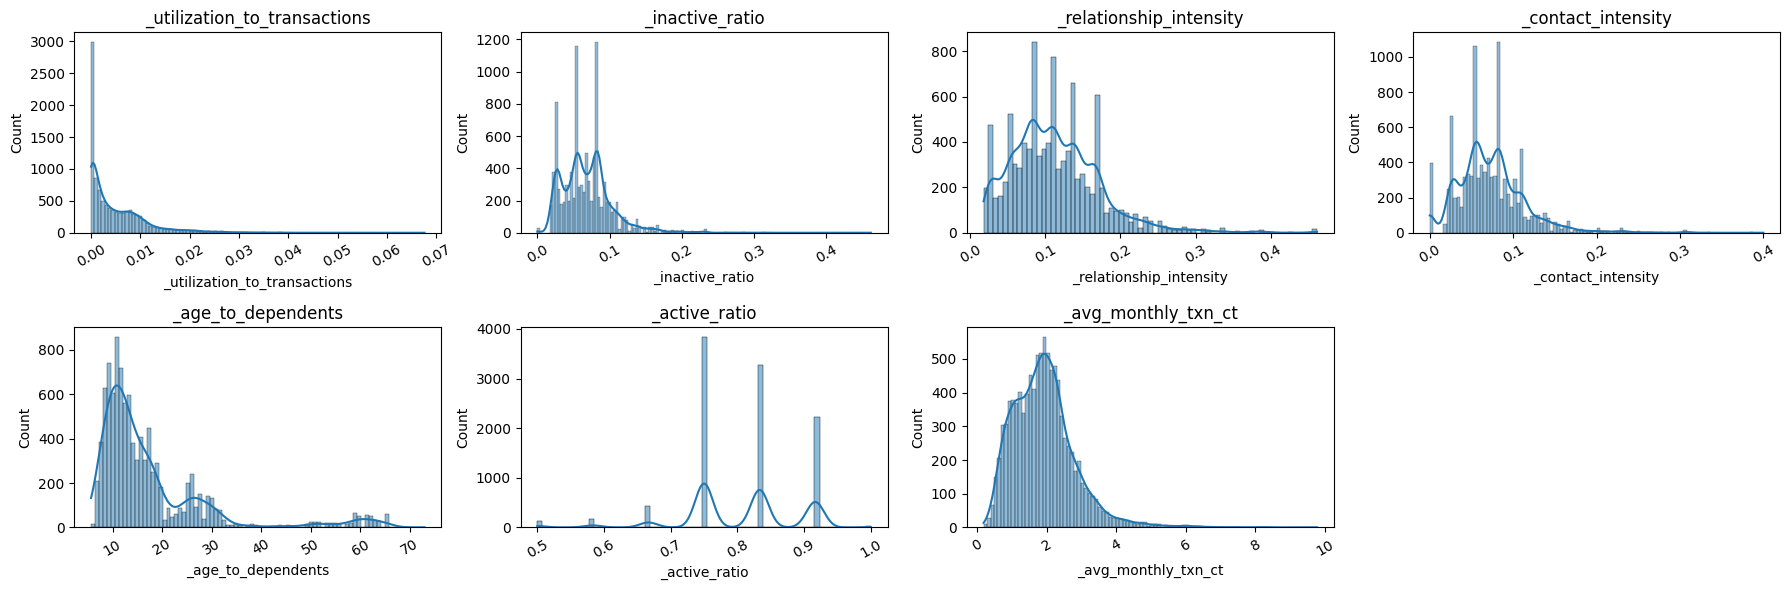

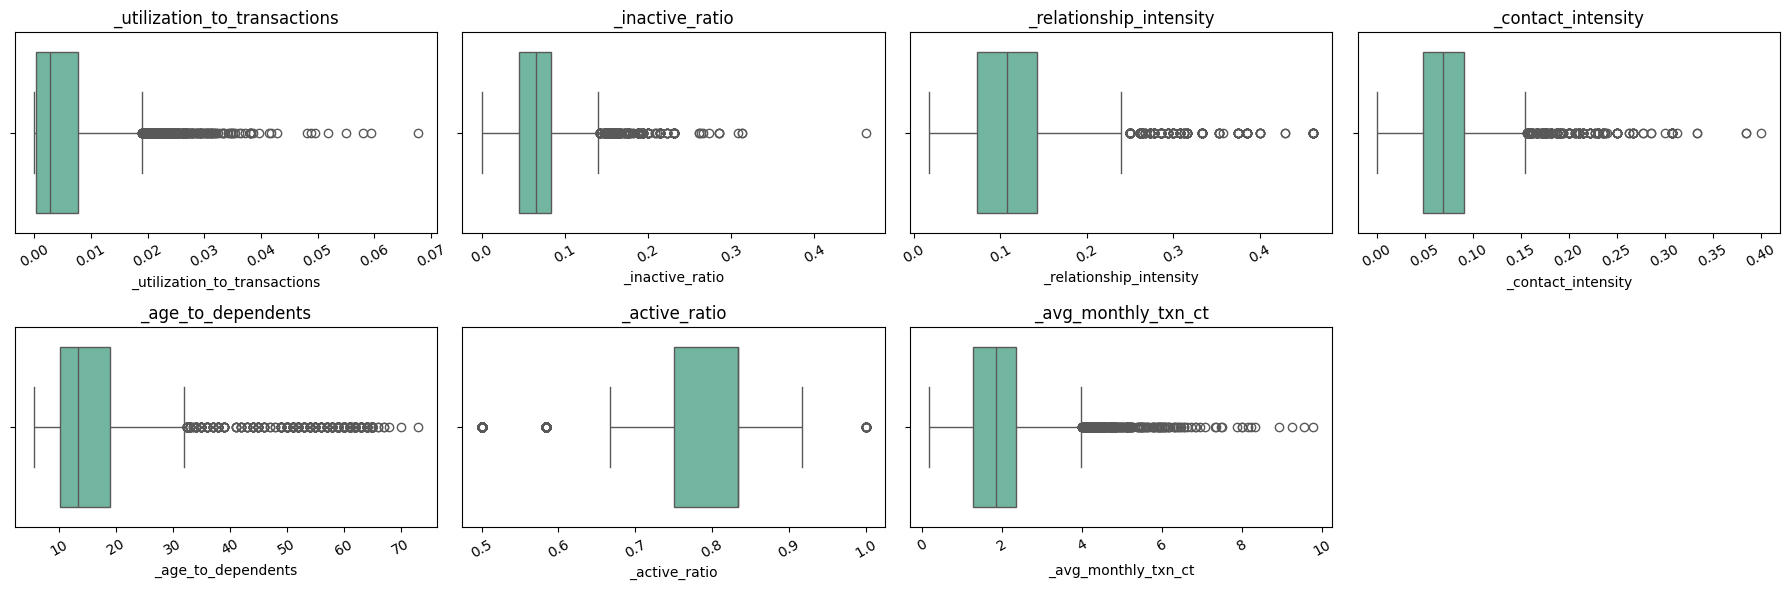

In [21]:
derived_col = []
for col in df.columns:
  if col.strip().startswith('_'):
    derived_col.append(col)

subplot_viz(derived_col, plot_type='hist', df=df)
subplot_viz(derived_col, plot_type='box',df=df)

In [22]:
df.describe(include='all')

,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,_utilization_to_transactions,_inactive_ratio,_relationship_intensity,_contact_intensity,_age_to_dependents,_active_ratio,_avg_monthly_txn_ct
count,10127.000000,10127.000000,10127,10127.000000,10127,10127,10127,10127,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
unique,NaN,NaN,2,NaN,7,4,6,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,F,NaN,Graduate,Married,Less than $40K,Blue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,5358,NaN,3128,4687,3561,9436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.160660,46.325960,NaN,2.346203,NaN,NaN,NaN,NaN,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894,0.004946,0.068603,0.113027,0.072898,17.482754,0.804903,1.923120
std,0.367235,8.016814,NaN,1.298908,NaN,NaN,NaN,NaN,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691,0.006000,0.034500,0.058911,0.041082,11.945983,0.084219,0.911977
min,0.000000,26.000000,NaN,0.000000,NaN,NaN,NaN,NaN,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.017857,0.000000,5.666667,0.500000,0.188679
25%,0.000000,41.000000,NaN,1.000000,NaN,NaN,NaN,NaN,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000,0.000285,0.045455,0.073171,0.047619,10.250000,0.750000,1.272727
50%,0.000000,46.000000,NaN,2.000000,NaN,NaN,NaN,NaN,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000,0.002824,0.065217,0.108108,0.068966,13.333333,0.833333,1.857143
75%,0.000000,52.000000,NaN,3.000000,NaN,NaN,NaN,NaN,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000,0.007769,0.083333,0.142857,0.090909,19.000000,0.833333,2.361111


할일
1. 일단 먼저 지금까지 만든 파생변수 직관적으로 해석
2. 분포보고 이게 말이 되는지 해석


In [23]:
cat_cols

['gender',
 'education_level',
 'marital_status',
 'income_category',
 'card_category']

In [24]:
# categorical values

from scipy.stats import chi2_contingency

result_chi = []
for col in cat_cols:
  contingency_table = pd.crosstab(df[col], df[target_col])
  chi2, p, dof, expected = chi2_contingency(contingency_table)

  result_chi.append({
      'feature':col,
      'chi2':chi2,
      'p-value':round(p,10)
  })

chi_df = pd.DataFrame(result_chi)
chi_df.sort_values(by='p-value')

,feature,chi2,p-value
0,gender,13.865614,0.000196
3,income_category,12.832259,0.025002
1,education_level,12.511205,0.051489
2,marital_status,6.056097,0.108913
4,card_category,2.234227,0.525238


1. 순서형 변수로 인코딩할 변수들 : income_category, education_level
2. card_category 의 경우 데이터 정보 부족으로 등급 체계인지 종류 차이인지 확인 불가 + <br> p-value에서 연관성이 약한 상태이므로 범주형으로 취급하기로 함.

In [25]:
df['income_category'].value_counts()

,count
income_category,
Less than $40K,3561
$40K - $60K,1790
$80K - $120K,1535
$60K - $80K,1402
Unknown,1112
$120K +,727


In [26]:
df['education_level'].value_counts()

,count
education_level,
Graduate,3128
High School,2013
Unknown,1519
Uneducated,1487
College,1013
Post-Graduate,516
Doctorate,451


In [27]:
# education_level
edu_order_mapping = {
    'Uneducated': 0,
    'High School': 1,
    'College': 2,
    'Graduate': 3,
    'Post-Graduate': 4,
    'Doctorate': 5,
    'Unknown': np.nan
}
df['education_level_encoded'] = df['education_level'].map(edu_order_mapping)
df['is_edu_unknown'] = df['education_level'] == 'Unknown'
# income_category
income_order = {
    'Less than $40K': 0,
    '$40K - $60K': 1,
    '$60K - $80K': 2,
    '$80K - $120K': 3,
    '$120K +': 4,
    'Unknown': np.nan
}

df['income_category_encoded'] = df['income_category'].map(income_order)
df['is_income_unknown'] = df['income_category'] == 'Unknown'

##  Feature Selection using Random Forest

- Train a Random Forest classifier
- Compute feature importance scores
- Select top N variables for interpretation
- Visualize SHAP values (optional)

🎯 Goal: Identify features most associated with churn behavior

##  Rule Extraction using Decision Tree

- Fit a shallow decision tree on selected features
- Extract rules (e.g., Rule 4, Rule 29, Rule 75, Rule 207)
- For each rule, calculate:
  - Total users covered
  - Churn count
  - Churn ratio (%)
- Visualize each rule's condition and outcome

📌 Focus on understanding behavior segments

##  Rule Comparison

- Compare extracted rules in terms of:
  - Average transaction count
  - Spending behavior
  - Activity recency
- Highlight key differences between Rule 207 and others
- Visualize distributions for each rule group

##  Sensitivity Analysis per Rule

- For each rule, modify critical variables and simulate outcomes
- Example: Increase total transaction count from 50 to 75
- Measure how many users change prediction from churn to retain
- Identify optimal intervention thresholds

✳️ Example: In Rule 207, increasing transaction count to 68 changes 54 churn predictions to retain

##  Strategic Recommendations

Based on sensitivity analysis:
- Rule 4: Promote frequent usage through loyalty campaigns
- Rule 207: Trigger retention messaging when transaction count drops below 68
- Rule 75: Offer personalized discount for low spenders

 Suggest specific actions tied to variable changes for each rule

## ✅ Summary & Next Steps

- Key churn rules were identified using decision trees
- Sensitivity analysis revealed actionable thresholds for intervention
- Retention strategies were proposed based on simulated improvements

Next Steps:
- A/B test retention campaigns based on rule segments
- Automate churn alert triggers
- Explore uplift modeling for personalized treatment